In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import json
from pyhaloxml.HaloXML import HaloXML
from shapely.geometry import shape
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [4]:
adata = sc.read_h5ad("/Users/izabellazamora/Desktop/HALO_annotation_trtransfer/data/HT224P1.h5ad")
annotation_path = "/Users/izabellazamora/Desktop/HALO_annotation_trtransfer/data/C1-HT224P1-S1Fc2U1.annotations"

In [13]:
adata = adata[adata.obs["in_tissue"] == 1]

In [7]:
# if not already stored in X and Y 
# adata.obs["X"] = adata.obsm["X_spatial"][:,0]
# adata.obs["Y"] = adata.obsm["X_spatial"][:,1]
adata.obs["X"] = adata.obs["pxl_row_in_fullres"]
adata.obs["Y"] = adata.obs["pxl_col_in_fullres"]
adata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,sample,X,Y
AAACAACGAATAGTTC-1,0,0,16,4140,1500,HT224P1,4140,1500
AAACAAGTATCTCCCA-1,1,50,102,14754,12376,HT224P1,14754,12376
AAACAATCTACTAGCA-1,0,3,43,7490,2170,HT224P1,7490,2170
AAACACCAATAACTGC-1,0,59,19,4431,14255,HT224P1,4431,14255
AAACAGAGCGACTCCT-1,0,14,94,13810,4589,HT224P1,13810,4589
...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,7289,14057,HT224P1,7289,14057
TTGTTTCATTAGTCTA-1,0,60,30,5796,14480,HT224P1,5796,14480
TTGTTTCCATACAACT-1,1,45,27,5444,11235,HT224P1,5444,11235
TTGTTTGTATTACACG-1,0,73,41,7144,17298,HT224P1,7144,17298


In [23]:
def transfer_halo_annotations_to_adata(
    annotation_path,
    adata,
    flip_x=False,
    flip_y=False,
    rotation=0, 
    x_shift=0,
    y_shift=0,
    align_to_visium=True,
    save_path=None,
    spot_diameter=55,
    plot=True,
):
    """
    Transfer HALO annotation labels to Visium spots in an AnnData object.

    Parameters
    ----------
    annotation_path : str
        Path to the .annotations file.
    adata : AnnData
        AnnData object with spatial coordinates in obsm["X_spatial"].
    flip_x : bool, default False
        Whether to flip the X coordinates.
    flip_y : bool, default False
        Whether to flip the Y coordinates.
    rotation : float, default 0
        Angle in degrees to rotate the coordinates (clockwise is positive).
        For example, rotation=90 rotates 90 degrees clockwise.
    x_shift : float, default 0
        Value to shift X coordinates.
    y_shift : float, default 0
        Value to shift Y coordinates.
    align_to_visium : bool, default True
        Whether to align annotation coordinates to Visium spots.
    save_path : str or None
        If provided, path to save the updated AnnData object.
    spot_diameter : float, default 55
        Diameter of Visium spots (in same units as coordinates).
    plot : bool, default True
        Whether to plot overlays and results.
    
    """
    # Load HALO annotations
    hx = HaloXML()
    hx.load(annotation_path)
    hx.matchnegative()

    geojson_feats = []
    labels = []

    for layer in hx.layers:
        feats = layer.as_geojson(matchnegative=True)
        for f in feats:
            geojson_feats.append(shape(f.geometry))
            labels.append(f.properties.get("classification", "Unlabeled"))

    gdf = gpd.GeoDataFrame({'label': labels, 'geometry': geojson_feats}, crs=None)
    gdf["label"] = gdf["label"].apply(lambda d: d.get("name") if isinstance(d, dict) else d)

    x = adata.obs["X"].copy()
    y = adata.obs["Y"].copy()

    # Optionally flip axes
    if flip_x:
        x = x.max() - (x - x.min())
    if flip_y:
        y = y.max() - (y - y.min())

    # Optionally align to Visium (default: same as original code)
    if align_to_visium:
        y_min = y.min()
        y_max = y.max()
        y_center = (y_max + y_min) / 2
        x_aligned = x + x_shift
        y_aligned = y_center - y + y_min + 450 + y_shift
    else:
        x_aligned = x + x_shift
        y_aligned = y + y_shift

    # Apply rotation if specified
    if rotation != 0:
        # Convert degrees to radians, and make positive values mean clockwise
        theta = -np.deg2rad(rotation)
        # Rotate around the center of the points
        x_mean = np.mean(x_aligned)
        y_mean = np.mean(y_aligned)
        x_shifted = x_aligned - x_mean
        y_shifted = y_aligned - y_mean
        x_rot = x_shifted * np.cos(theta) - y_shifted * np.sin(theta)
        y_rot = x_shifted * np.sin(theta) + y_shifted * np.cos(theta)
        x_aligned = x_rot + x_mean
        y_aligned = y_rot + y_mean

    # Create GeoDataFrame for Visium spots
    spots_gdf = gpd.GeoDataFrame(
        adata.obs.copy(),
        geometry=gpd.points_from_xy(
            x_aligned,
            y_aligned
        ),
        crs=None
    )

    if plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        gdf.plot(
            ax=ax,
            column="label",
            categorical=True,
            legend=True,
            cmap="tab20",
            edgecolor="black",
            linewidth=0.5,
            alpha=0.4
        )
        # Plot each spot as a circle with the correct diameter
        spot_radius = spot_diameter / 2
        for x0, y0 in zip(x_aligned, y_aligned):
            circle = plt.Circle((x0, y0), spot_radius, color='black', alpha=0.5, fill=False, linewidth=1)
            ax.add_patch(circle)
        # Optionally, overlay the spot centers as points for clarity
        ax.scatter(
            x_aligned, y_aligned,
            color='black',
            s=8,
            alpha=0.8,
            label='Visium Spot Centers'
        )
        plt.title("Halo Annotations and Visium Spots (Spot Diameter Shown)")
        plt.axis("equal")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Buffer spots to create spot areas
    spot_radius = spot_diameter / 2
    buffered_spots_gdf = gpd.GeoDataFrame(
        adata.obs.copy(),
        geometry=[Point(x, y).buffer(spot_radius) for x, y in zip(x_aligned, y_aligned)],
        crs=None
    )
    # Ensure both are GeoDataFrames
    buffered_spots_gdf = gpd.GeoDataFrame(buffered_spots_gdf, geometry='geometry', crs=None)
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs=None)

    # Drop the 'barcode' column if it exists before resetting index
    if 'barcode' in buffered_spots_gdf.columns:
        buffered_spots_gdf = buffered_spots_gdf.drop(columns=['barcode'])

    # Spatial join: which annotation polygons overlap each spot
    joined = gpd.sjoin(buffered_spots_gdf, gdf, how="left", predicate="intersects")

    label_counts = joined.groupby([joined.index, "label"]).size().unstack(fill_value=0)
    label_percentages = label_counts.div(label_counts.sum(axis=1), axis=0)

    dominant_label = label_percentages.idxmax(axis=1)
    max_fraction = label_percentages.max(axis=1)

    adata.obs["halo_label"] = adata.obs.index.map(dominant_label)
    adata.obs["halo_label_frac"] = adata.obs.index.map(max_fraction)

    for label in label_percentages.columns:
        adata.obs[f"halo_frac_{label}"] = adata.obs.index.map(label_percentages[label])

    if save_path is not None:
        print(f"Saving updated AnnData to {save_path} ...")
        adata.write_h5ad(save_path)

    if plot:
        print("Plotting halo-labeled scatter plot...")
        fig, ax = plt.subplots(figsize=(8, 8))
        scatter = ax.scatter(
            x_aligned, y_aligned,
            c=adata.obs["halo_label"].astype("category").cat.codes,
            cmap="tab20", s=10, alpha=0.8
        )
        ax.set_title("Scatter by Halo Label")
        ax.set_xlabel("X (transformed)")
        ax.set_ylabel("Y (transformed)")
        plt.axis("equal")
        plt.show()

    return adata

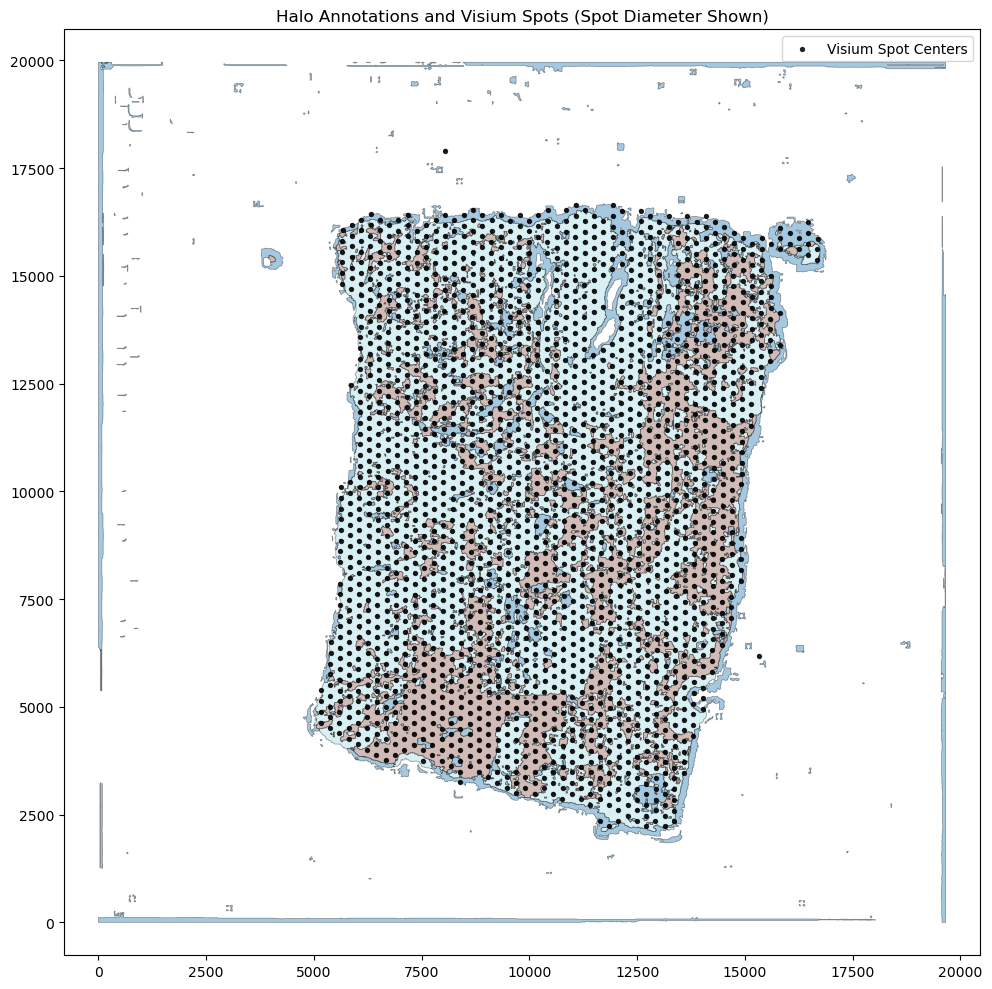

Plotting halo-labeled scatter plot...


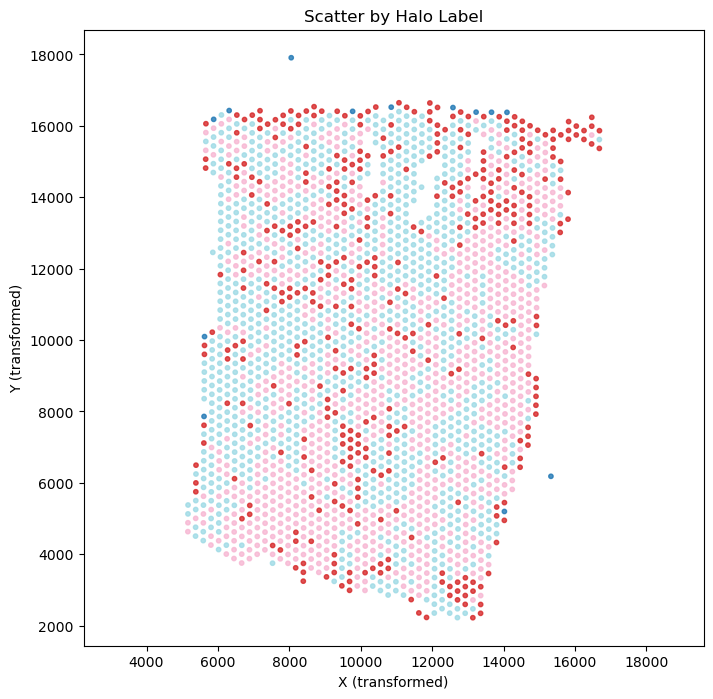

In [25]:
updated_adata = transfer_halo_annotations_to_adata(
    annotation_path=annotation_path,
    adata=adata,
    flip_x=True,
    flip_y=False,
    rotation = 90,
    x_shift= 300,
    y_shift=-500,
    align_to_visium=False, # Set to false if just testing alignment 
    save_path=None, # can save off 
    spot_diameter=55,
    plot=True
)